In [35]:
# A2C paper: https://arxiv.org/pdf/1602.01783v2
# Implementation based on Algorithm S3 - Asynchronous Advantage Actor-Critic

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from matplotlib import pyplot as plt

In [36]:
class CartpoleEnvironment:
  def __init__(self):
    self.env = gym.make('CartPole-v1')
    self.state_dim = self.env.observation_space.shape[0]  
    self.action_dim = self.env.action_space.n
    self.num_steps = 0

    self.running_mean = np.zeros(self.state_dim)
    self.running_std = np.ones(self.state_dim)
    
  def norm_state(self, state):
    # https://builtin.com/articles/mean-normalization
    state_array = np.array(state)
    normalized_state = (state_array - self.running_mean) / (self.running_std + 1e-8)
    return normalized_state

  def update_state_norm(self, state):
    self.num_steps += 1
    # n = self.num_steps
    state_array = np.array(state)
    
    # https://stackoverflow.com/questions/12636613/how-to-calculate-moving-average-without-keeping-the-count-and-data-total
    self.running_mean = self.running_mean * ((self.num_steps-1)/self.num_steps) + state_array * (1/self.num_steps)

    # https://stackoverflow.com/questions/1174984/how-to-efficiently-calculate-a-running-standard-deviation
    squared_diff = (state_array - self.running_mean) ** 2
    self.running_std = np.sqrt(
        self.running_std ** 2 * ((self.num_steps-1)/self.num_steps) + squared_diff * (1/self.num_steps)
    )
    
  def step(self, action):
    next_state, reward, terminated, truncated, info = self.env.step(action)
    self.update_state_norm(next_state)
    normalized_next_state = self.norm_state(next_state)
    isDone = terminated or truncated
    return normalized_next_state, reward, isDone, info
    
  def reset(self):
    state, _ = self.env.reset()
    self.update_state_norm(state)
    normalized_state = self.norm_state(state)
    return normalized_state

In [37]:
class ActorCritic(nn.Module):
    # initialization based on this A2C cartpole initialization
    # https://github.com/floodsung/a2c_cartpole_pytorch/blob/master/a2c_cartpole.py
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # common layers
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        output = F.relu(self.fc1(state))
        output = F.relu(self.fc2(output))
        action_log_probabilities = F.log_softmax(self.fc3(output), dim=-1)
        state_value = self.fc4(output)
        return action_log_probabilities, state_value

    def select_action(self, state):
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state).to(self.device)
        
        with torch.no_grad():
            action_log_probabilities, _ = self.forward(state)
            action_probabilities = torch.exp(action_log_probabilities)
            dist = Categorical(action_probabilities)
            action = dist.sample()
            action_log_probability = dist.log_prob(action)
        
        return action.item(), action_log_probability.item()
    
    def get_value(self, state):
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state).to(self.device)
        _, state_value = self.forward(state)
        return state_value
    
    def evaluate(self, state, action):
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state).to(self.device)
        if isinstance(action, np.ndarray):
            action = torch.FloatTensor(action).to(self.device)

        action_log_probabilities, state_values = self.forward(state)
        action_probabilities = torch.exp(action_log_probabilities)
        dist = Categorical(action_probabilities)
        action_log_probabilities = dist.log_prob(action)
        dist_entropy = dist.entropy()

        return action_log_probabilities, state_values, dist_entropy

In [38]:
class A2CAgent:
    def __init__(self, state_dim, action_dim, learning_rate=1e-3, gamma=0.99):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Training on: {self.device}")
        self.gamma = gamma
        self.model = ActorCritic(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.episode_reward_history = []
        self.average_reward_history = []
    
    def train(self, num_episodes=1500, max_steps=500):
        env = CartpoleEnvironment()

        # iterate through episodes
        for episode in range(num_episodes):
            state = env.reset()
            curr_episode_reward = 0
            states = []
            actions = []
            action_log_probabilities = []
            rewards = []

            # iterate through steps per episode
            for step in range(max_steps):
                action, action_log_probability = self.model.select_action(state)
                next_state, reward, isDone, _ = env.step(action)

                # add histories to lists
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                action_log_probabilities.append(action_log_probability)

                state = next_state
                curr_episode_reward += reward

                if isDone:
                    break
            
            self.episode_reward_history.append(curr_episode_reward)
            self.update_policy_params(states, actions, rewards)

            # calculate average reward for smoother graph
            if len(self.episode_reward_history) >= 100:
                # calc mean for last 100 episodes
                average_reward = np.mean(self.episode_reward_history[-100:])
                self.average_reward_history.append(average_reward)

                if average_reward >= 475 and episode >= 100:
                    print(f"\nEnvironment was solved in {episode + 1} episodes.\n")
                    break
                
            else:
                average_reward = np.mean(self.episode_reward_history)
                self.average_reward_history.append(average_reward)
                
            if (episode + 1) % 20 == 0:
                print(f"Episode {episode + 1}, Average Reward (last 100): {average_reward:.2f}")

        return self.episode_reward_history, self.average_reward_history

    def update_policy_params(self, states, actions, rewards):
        returns = []
        R = 0

        # discount rewards based on
        # https://github.com/floodsung/a2c_cartpole_pytorch/blob/master/a2c_cartpole.py
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.FloatTensor(returns).to(self.device)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        
        values = self.model.get_value(states)
        advantages = returns - values.detach().squeeze()
        
        action_log_probs, state_values, dist_entropy = self.model.evaluate(states, actions)
            
        policy_loss = -(advantages.detach() * action_log_probs).mean()
        value_loss = F.mse_loss(state_values.squeeze(), returns)
        total_loss = policy_loss + 0.5 * value_loss
        
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

def main():
    env = CartpoleEnvironment()  # Create instance
    agent = A2CAgent(env.state_dim, env.action_dim)
    rewards, average_rewards = agent.train()

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Episode Reward', alpha=0.3)
    plt.plot(average_rewards, label='Average Reward (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('A2C Rewards as a Function of Episodes')
    plt.legend()
    plt.grid()
    plt.show()


Training on: cuda
Episode 20, Average Reward (last 100): 25.45
Episode 40, Average Reward (last 100): 22.15
Episode 60, Average Reward (last 100): 22.93
Episode 80, Average Reward (last 100): 24.50
Episode 100, Average Reward (last 100): 26.05
Episode 120, Average Reward (last 100): 27.60
Episode 140, Average Reward (last 100): 30.84
Episode 160, Average Reward (last 100): 37.90
Episode 180, Average Reward (last 100): 38.90
Episode 200, Average Reward (last 100): 46.30
Episode 220, Average Reward (last 100): 57.45
Episode 240, Average Reward (last 100): 63.49
Episode 260, Average Reward (last 100): 81.86
Episode 280, Average Reward (last 100): 115.24
Episode 300, Average Reward (last 100): 112.68
Episode 320, Average Reward (last 100): 117.64
Episode 340, Average Reward (last 100): 157.26
Episode 360, Average Reward (last 100): 179.37
Episode 380, Average Reward (last 100): 198.99
Episode 400, Average Reward (last 100): 263.39
Episode 420, Average Reward (last 100): 318.35
Episode 440,

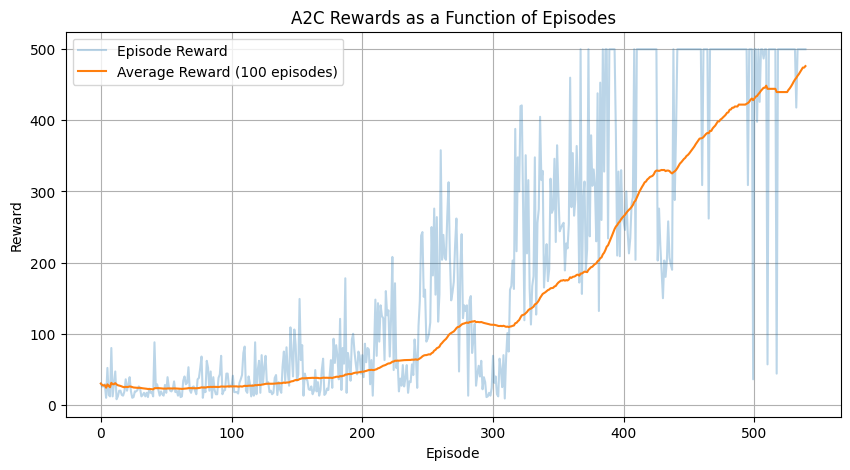

In [39]:
if __name__ == "__main__":
    main()